In [46]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

# import libraries:
import sys, os
import os
import git
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
os.chdir(path_git); os.sys.path.append('./fr_mcmc/utils/')
from change_of_parameters import omega_CDM_to_luisa

sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'../..')))
#path_git = git.Repo('.', search_parent_directories=True).working_tree_dir


from getdist import plots
import getdist
from getdist import plots, MCSamples, loadMCSamples
getdist.chains.print_load_details = False
import scipy
import numpy as np

from matplotlib import pyplot as plt
from scipy.linalg import sqrtm

from seaborn import heatmap
import pandas as pd
import emcee


def F_H(H, params, model):     
    lamb, L, beta, L_bar = params
    if model == 'GILA':
        FH = H**2 \
           + H**8 * L**6     * lamb * np.exp(lamb*(L*H)**2) \
           - H**6 * L_bar**4 * beta * np.exp(-beta*(L_bar*H)**10)
    
    elif model == 'BETA':
        FH = H**2 \
            + H**8 * L**6 * lamb * np.exp(lamb*(L*H)**4) \
            - H**2        * beta * np.exp(-beta*(L_bar*H)**8) 

    return FH

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
discard=0
thin=1
root_dic = '/home/matias/Documents/Repos/GILA-output/paper/'

# Get the samples:
samples_lcdm = emcee.backends.HDFBackend(root_dic + 'sample_LCDM_PPS_CC_3params/sample_LCDM_PPS_CC_3params.h5')
samples_beta = emcee.backends.HDFBackend(root_dic + 'sample_BETA_PPS_CC_3params/sample_BETA_PPS_CC_3params.h5')
samples_gila = emcee.backends.HDFBackend(root_dic + 'sample_GILA_PPS_CC_3params/sample_GILA_PPS_CC_3params.h5')

# Get the samples:
samples_lcdm_desi = emcee.backends.HDFBackend(root_dic + 'sample_LCDM_PPS_CC_DESI_4params/sample_LCDM_PPS_CC_DESI_4params.h5')
samples_beta_desi = emcee.backends.HDFBackend(root_dic + 'sample_BETA_PPS_CC_DESI_4params/sample_BETA_PPS_CC_DESI_4params.h5')
samples_gila_desi = emcee.backends.HDFBackend(root_dic + 'sample_GILA_PPS_CC_DESI_4params/sample_GILA_PPS_CC_DESI_4params.h5')


#nwalkers, ndim = reader_lcdm.shape #Number of walkers and parameters
flat_samples_beta = samples_beta.get_chain(discard=discard, flat=True, thin=thin)
flat_samples_gila = samples_gila.get_chain(discard=discard, flat=True, thin=thin)
flat_samples_lcdm = samples_lcdm.get_chain(discard=discard, flat=True, thin=thin)

flat_samples_beta_desi = samples_beta_desi.get_chain(discard=discard, flat=True, thin=thin)
flat_samples_gila_desi = samples_gila_desi.get_chain(discard=discard, flat=True, thin=thin)
flat_samples_lcdm_desi = samples_lcdm_desi.get_chain(discard=discard, flat=True, thin=thin)


omega_r = 2.47e-5 
L_bar = 0.90
names_LCDM = ['M_{{abs}}','H_0','\omega_m','\Omega_{{m}}^{{LCDM}}','\Omega_{{\\Lambda}}^{{LCDM}}']
labels_LCDM = names_LCDM
names_GILA = ['M_{{abs}}','\\beta','H_0','\omega_m','\Omega_{{m}}^{{GILA-\\beta}}','\Omega_{{m}}^{{LCDM}}','\Omega_{{\\Lambda}}^{{LCDM}}']
labels_GILA = names_GILA

names_GILA_1 = ['\\beta','H_0','\omega_m','\Omega_{{m}}^{{GILA-\\beta}}']
names_GILA_2 = ['\omega_m','\Omega_{{m}}^{{LCDM}}','\Omega_{{\\Lambda}}^{{LCDM}}']

In [48]:
#LCDM MODEL
M_abs = flat_samples_lcdm[:,0]
omega_m = flat_samples_lcdm[:,1]
H0 = flat_samples_lcdm[:,2]


Omega_r_lcdm = omega_r / (H0/100)**2
Omega_m_lcdm = omega_m / (H0/100)**2
Omega_L_lcdm = 1 - Omega_m_lcdm - Omega_r_lcdm

chains_lcdm = np.zeros((len(M_abs),5))
chains_lcdm[:,0] = M_abs
chains_lcdm[:,1] = H0
chains_lcdm[:,2] = omega_m
chains_lcdm[:,3] = Omega_m_lcdm
chains_lcdm[:,4] = Omega_L_lcdm

#BETA MODEL
M_abs = flat_samples_beta[:,0]
beta = flat_samples_beta[:,1]
H0 = flat_samples_beta[:,2]
#omega_m = flat_samples_beta[:,3]

omega_m = F_H(H0, [0, 0, beta, 0.9/H0], 'BETA')/(100**2) - omega_r

Omega_r_lcdm = omega_r / (H0/100)**2
Omega_m_lcdm = omega_m / (H0/100)**2
Omega_m_gila_B2 = omega_m / (F_H(H0, [0, 0, beta, 0.90/H0], 'BETA')/100**2)

Omega_m_gila = omega_CDM_to_luisa(beta, L_bar, H0, Omega_m_lcdm, model = 'BETA')
Omega_L_lcdm = 1 - Omega_m_lcdm - Omega_r_lcdm

chains_beta = np.zeros((len(M_abs),7))
chains_beta[:,0] = M_abs
chains_beta[:,1] = beta
chains_beta[:,2] = H0
chains_beta[:,3] = omega_m
chains_beta[:,4] = Omega_m_gila
chains_beta[:,5] = Omega_m_lcdm
chains_beta[:,6] = Omega_L_lcdm

#GILA MODEL

M_abs = flat_samples_gila[:,0]
beta = flat_samples_gila[:,1]
H0 = flat_samples_gila[:,2]
#omega_m = flat_samples_gila[:,3]

omega_m = F_H(H0, [0, 0, beta, 0.9/H0], 'GILA')/(100**2) - omega_r

Omega_r_lcdm = omega_r / (H0/100)**2
Omega_m_lcdm = omega_m / (H0/100)**2
Omega_m_gila_B2 = omega_m / (F_H(H0, [0, 0, beta, 0.90/H0], 'GILA')/100**2)

Omega_m_gila = omega_CDM_to_luisa(beta, L_bar, H0, Omega_m_lcdm, model = 'GILA')
Omega_L_lcdm = 1 - Omega_m_lcdm - Omega_r_lcdm

chains_gila = np.zeros((len(M_abs),7))
chains_gila[:,0] = M_abs
chains_gila[:,1] = beta
chains_gila[:,2] = H0
chains_gila[:,3] = omega_m
chains_gila[:,4] = Omega_m_gila
chains_gila[:,5] = Omega_m_lcdm
chains_gila[:,6] = Omega_L_lcdm


samples1 = MCSamples(samples=chains_beta, names=names_GILA, labels=names_GILA)
samples1 = samples1.copy(label=r'Lowest-order with $0.3\sigma$ smoothing',
			settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.3,
			'smooth_scale_1D':0.3})

samples2 = MCSamples(samples=chains_gila, names=names_GILA, labels=names_GILA)
samples2 = samples2.copy(label=r'Lowest-order with $0.3\sigma$ smoothing',
			settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.3,
			'smooth_scale_1D':0.3})

samples3 = MCSamples(samples=chains_lcdm, names=names_LCDM, labels=names_LCDM)
samples3 = samples3.copy(label=r'Lowest-order with $0.3\sigma$ smoothing',
			settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.3,
			'smooth_scale_1D':0.3})

In [49]:
print(flat_samples_lcdm_desi)
print(flat_samples_beta_desi)
print(flat_samples_gila_desi)

[[-1.93564980e+01  1.45759250e+02  1.41800282e-01  6.93960495e+01]
 [-1.94512319e+01  1.45406809e+02  1.44619149e-01  7.04410816e+01]
 [-1.94025242e+01  1.46295702e+02  1.45836374e-01  6.97220813e+01]
 ...
 [-1.92958114e+01  1.40207739e+02  1.57319386e-01  7.22002619e+01]
 [-1.93524995e+01  1.41973498e+02  1.56140669e-01  7.02003226e+01]
 [-1.93254973e+01  1.41827760e+02  1.56995666e-01  7.11303745e+01]]
[[-19.04285221 139.14036977   0.82092481  70.50218179]
 [-19.4430646  138.97631739   0.80514226  69.84191247]
 [-19.42577944 142.86724945   0.81737637  68.09737624]
 ...
 [-19.31805522 140.09590759   0.83353619  71.68914509]
 [-19.27790466 138.55916978   0.86605777  73.55599215]
 [-19.31195659 142.74035584   0.94313747  72.39012818]]
[[-19.36541376 140.0290098    1.33167024  70.25361023]
 [-19.39669201 140.80448667   1.32321063  69.10572048]
 [-19.51444968 136.97432276   1.33952725  69.61206156]
 ...
 [-19.27284345 139.06947279   1.54199368  73.30788861]
 [-19.29258338 143.03324474   1

In [50]:
#LCDM MODEL
M_abs = flat_samples_lcdm_desi[:,0]
rd = flat_samples_lcdm_desi[:,1]
omega_m = flat_samples_lcdm_desi[:,2]
H0 = flat_samples_lcdm_desi[:,3]

Omega_r_lcdm = omega_r / (H0/100)**2
Omega_m_lcdm = omega_m / (H0/100)**2
Omega_L_lcdm = 1 - Omega_m_lcdm - Omega_r_lcdm

chains_lcdm_desi = np.zeros((len(M_abs),5))
chains_lcdm_desi[:,0] = M_abs
chains_lcdm_desi[:,1] = H0
chains_lcdm_desi[:,2] = omega_m
chains_lcdm_desi[:,3] = Omega_m_lcdm
chains_lcdm_desi[:,4] = Omega_L_lcdm

#BETA MODEL
M_abs = flat_samples_beta_desi[:,0]
#rd = flat_samples_beta_desi[:,1]
beta = flat_samples_beta_desi[:,2]
H0 = flat_samples_beta_desi[:,3]

omega_m = F_H(H0, [0, 0, beta, 0.9/H0], 'BETA')/(100**2) - omega_r

Omega_r_lcdm = omega_r / (H0/100)**2
Omega_m_lcdm = omega_m / (H0/100)**2
Omega_m_gila_B2 = omega_m / (F_H(H0, [0, 0, beta, 0.90/H0], 'BETA')/100**2)

Omega_m_gila = omega_CDM_to_luisa(beta, L_bar, H0, Omega_m_lcdm, model = 'BETA')
Omega_L_lcdm = 1 - Omega_m_lcdm - Omega_r_lcdm

chains_beta_desi = np.zeros((len(M_abs),7))
chains_beta_desi[:,0] = M_abs
chains_beta_desi[:,1] = beta
chains_beta_desi[:,2] = H0
chains_beta_desi[:,3] = omega_m
chains_beta_desi[:,4] = Omega_m_gila
chains_beta_desi[:,5] = Omega_m_lcdm
chains_beta_desi[:,6] = Omega_L_lcdm

#GILA MODEL

M_abs = flat_samples_gila_desi[:,0]
#rd = flat_samples_gila_desi[:,1]
beta = flat_samples_gila_desi[:,2]
H0 = flat_samples_gila_desi[:,3]


omega_m = F_H(H0, [0, 0, beta, 0.9/H0], 'GILA')/(100**2) - omega_r

Omega_r_lcdm = omega_r / (H0/100)**2
Omega_m_lcdm = omega_m / (H0/100)**2
Omega_m_gila_B2 = omega_m / (F_H(H0, [0, 0, beta, 0.90/H0], 'GILA')/100**2)

Omega_m_gila = omega_CDM_to_luisa(beta, L_bar, H0, Omega_m_lcdm, model = 'GILA')
Omega_L_lcdm = 1 - Omega_m_lcdm - Omega_r_lcdm

chains_gila_desi = np.zeros((len(M_abs),7))
chains_gila_desi[:,0] = M_abs
chains_gila_desi[:,1] = beta
chains_gila_desi[:,2] = H0
chains_gila_desi[:,3] = omega_m
chains_gila_desi[:,4] = Omega_m_gila
chains_gila_desi[:,5] = Omega_m_lcdm
chains_gila_desi[:,6] = Omega_L_lcdm


samples1_desi = MCSamples(samples=chains_beta_desi, names=names_GILA, labels=names_GILA)
samples1_desi= samples1_desi.copy(label=r'Lowest-order with $0.3\sigma$ smoothing',
			settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.3,
			'smooth_scale_1D':0.3})

samples2_desi = MCSamples(samples=chains_gila_desi, names=names_GILA, labels=names_GILA)
samples2_desi = samples2_desi.copy(label=r'Lowest-order with $0.3\sigma$ smoothing',
			settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.3,
			'smooth_scale_1D':0.3})

samples3_desi = MCSamples(samples=chains_lcdm_desi, names=names_LCDM, labels=names_LCDM)
samples3_desi = samples3_desi.copy(label=r'Lowest-order with $0.3\sigma$ smoothing',
			settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.3,
			'smooth_scale_1D':0.3})

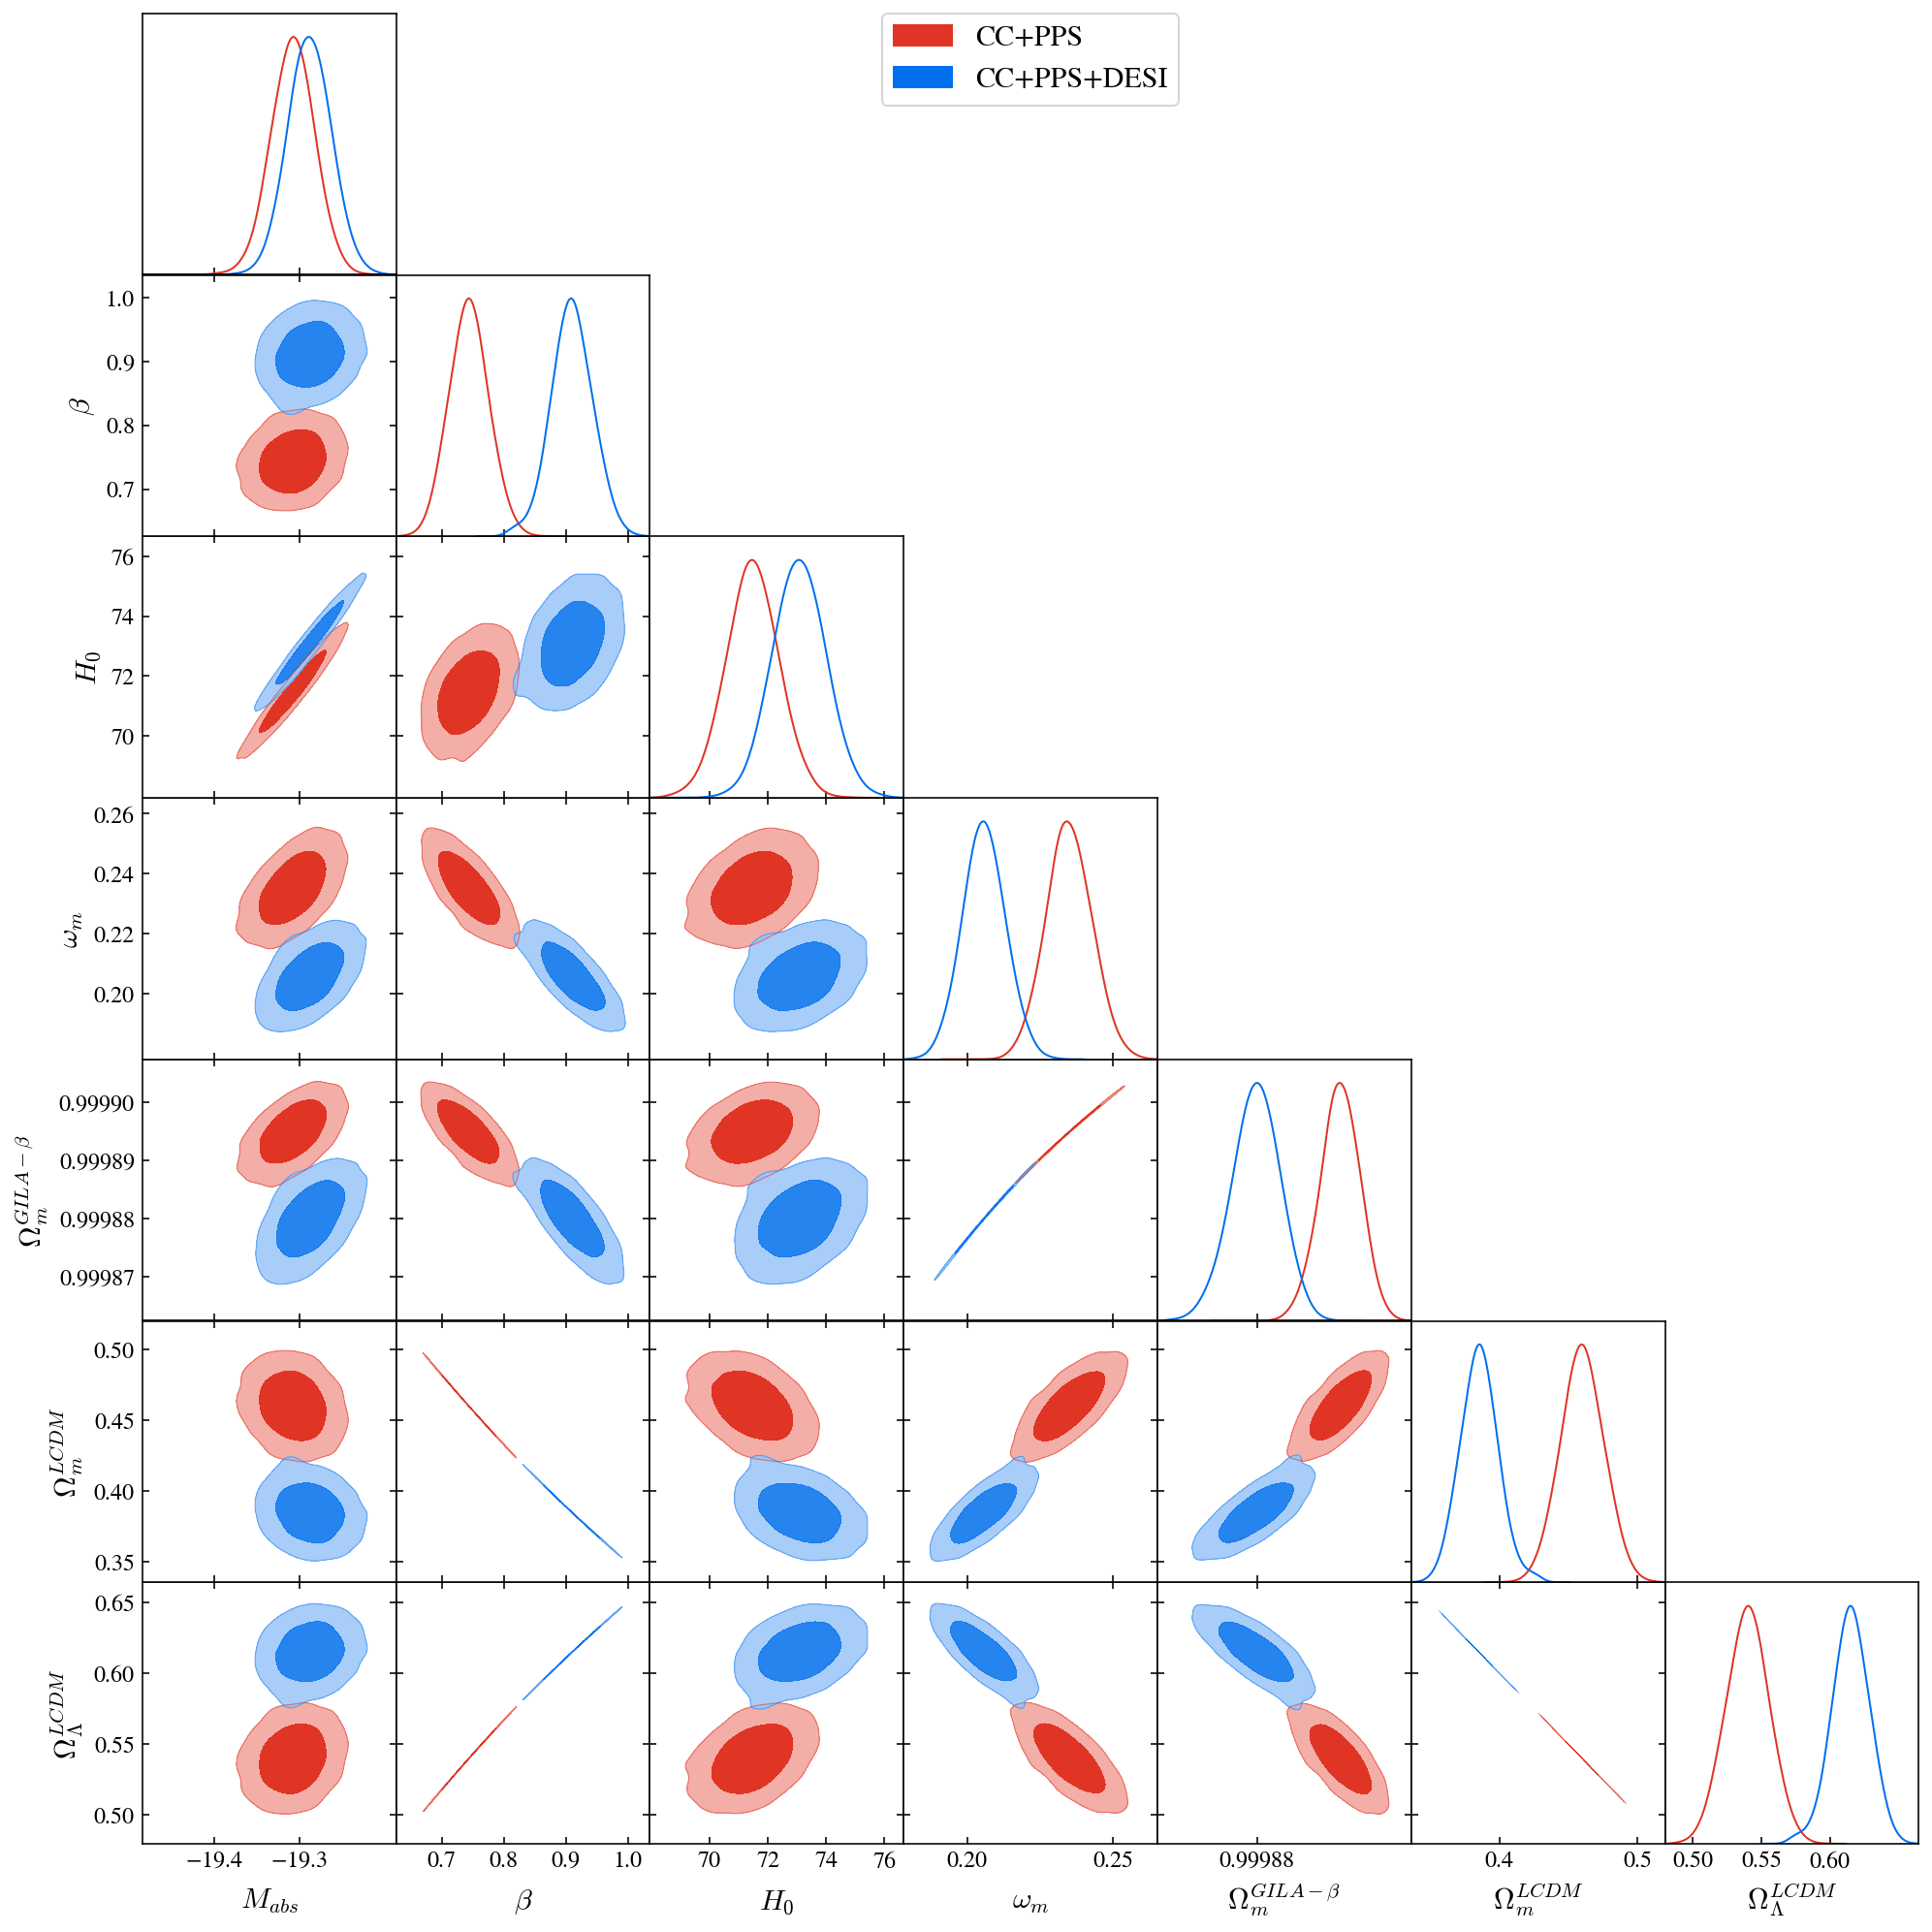

In [51]:
g = plots.get_subplot_plotter()
g.settings.legend_fontsize = 18
g.settings.axes_fontsize = 15
g.settings.axes_labelsize = 18
g.triangle_plot([samples1, samples1_desi],
				filled=True, params=names_GILA,
				contour_lws=1,
				legend_labels=['CC+PPS','CC+PPS+DESI'])
g.export(root_dic + 'triangle_plot_beta_CC+PPS+DESI_{}.pdf'.format(L_bar))

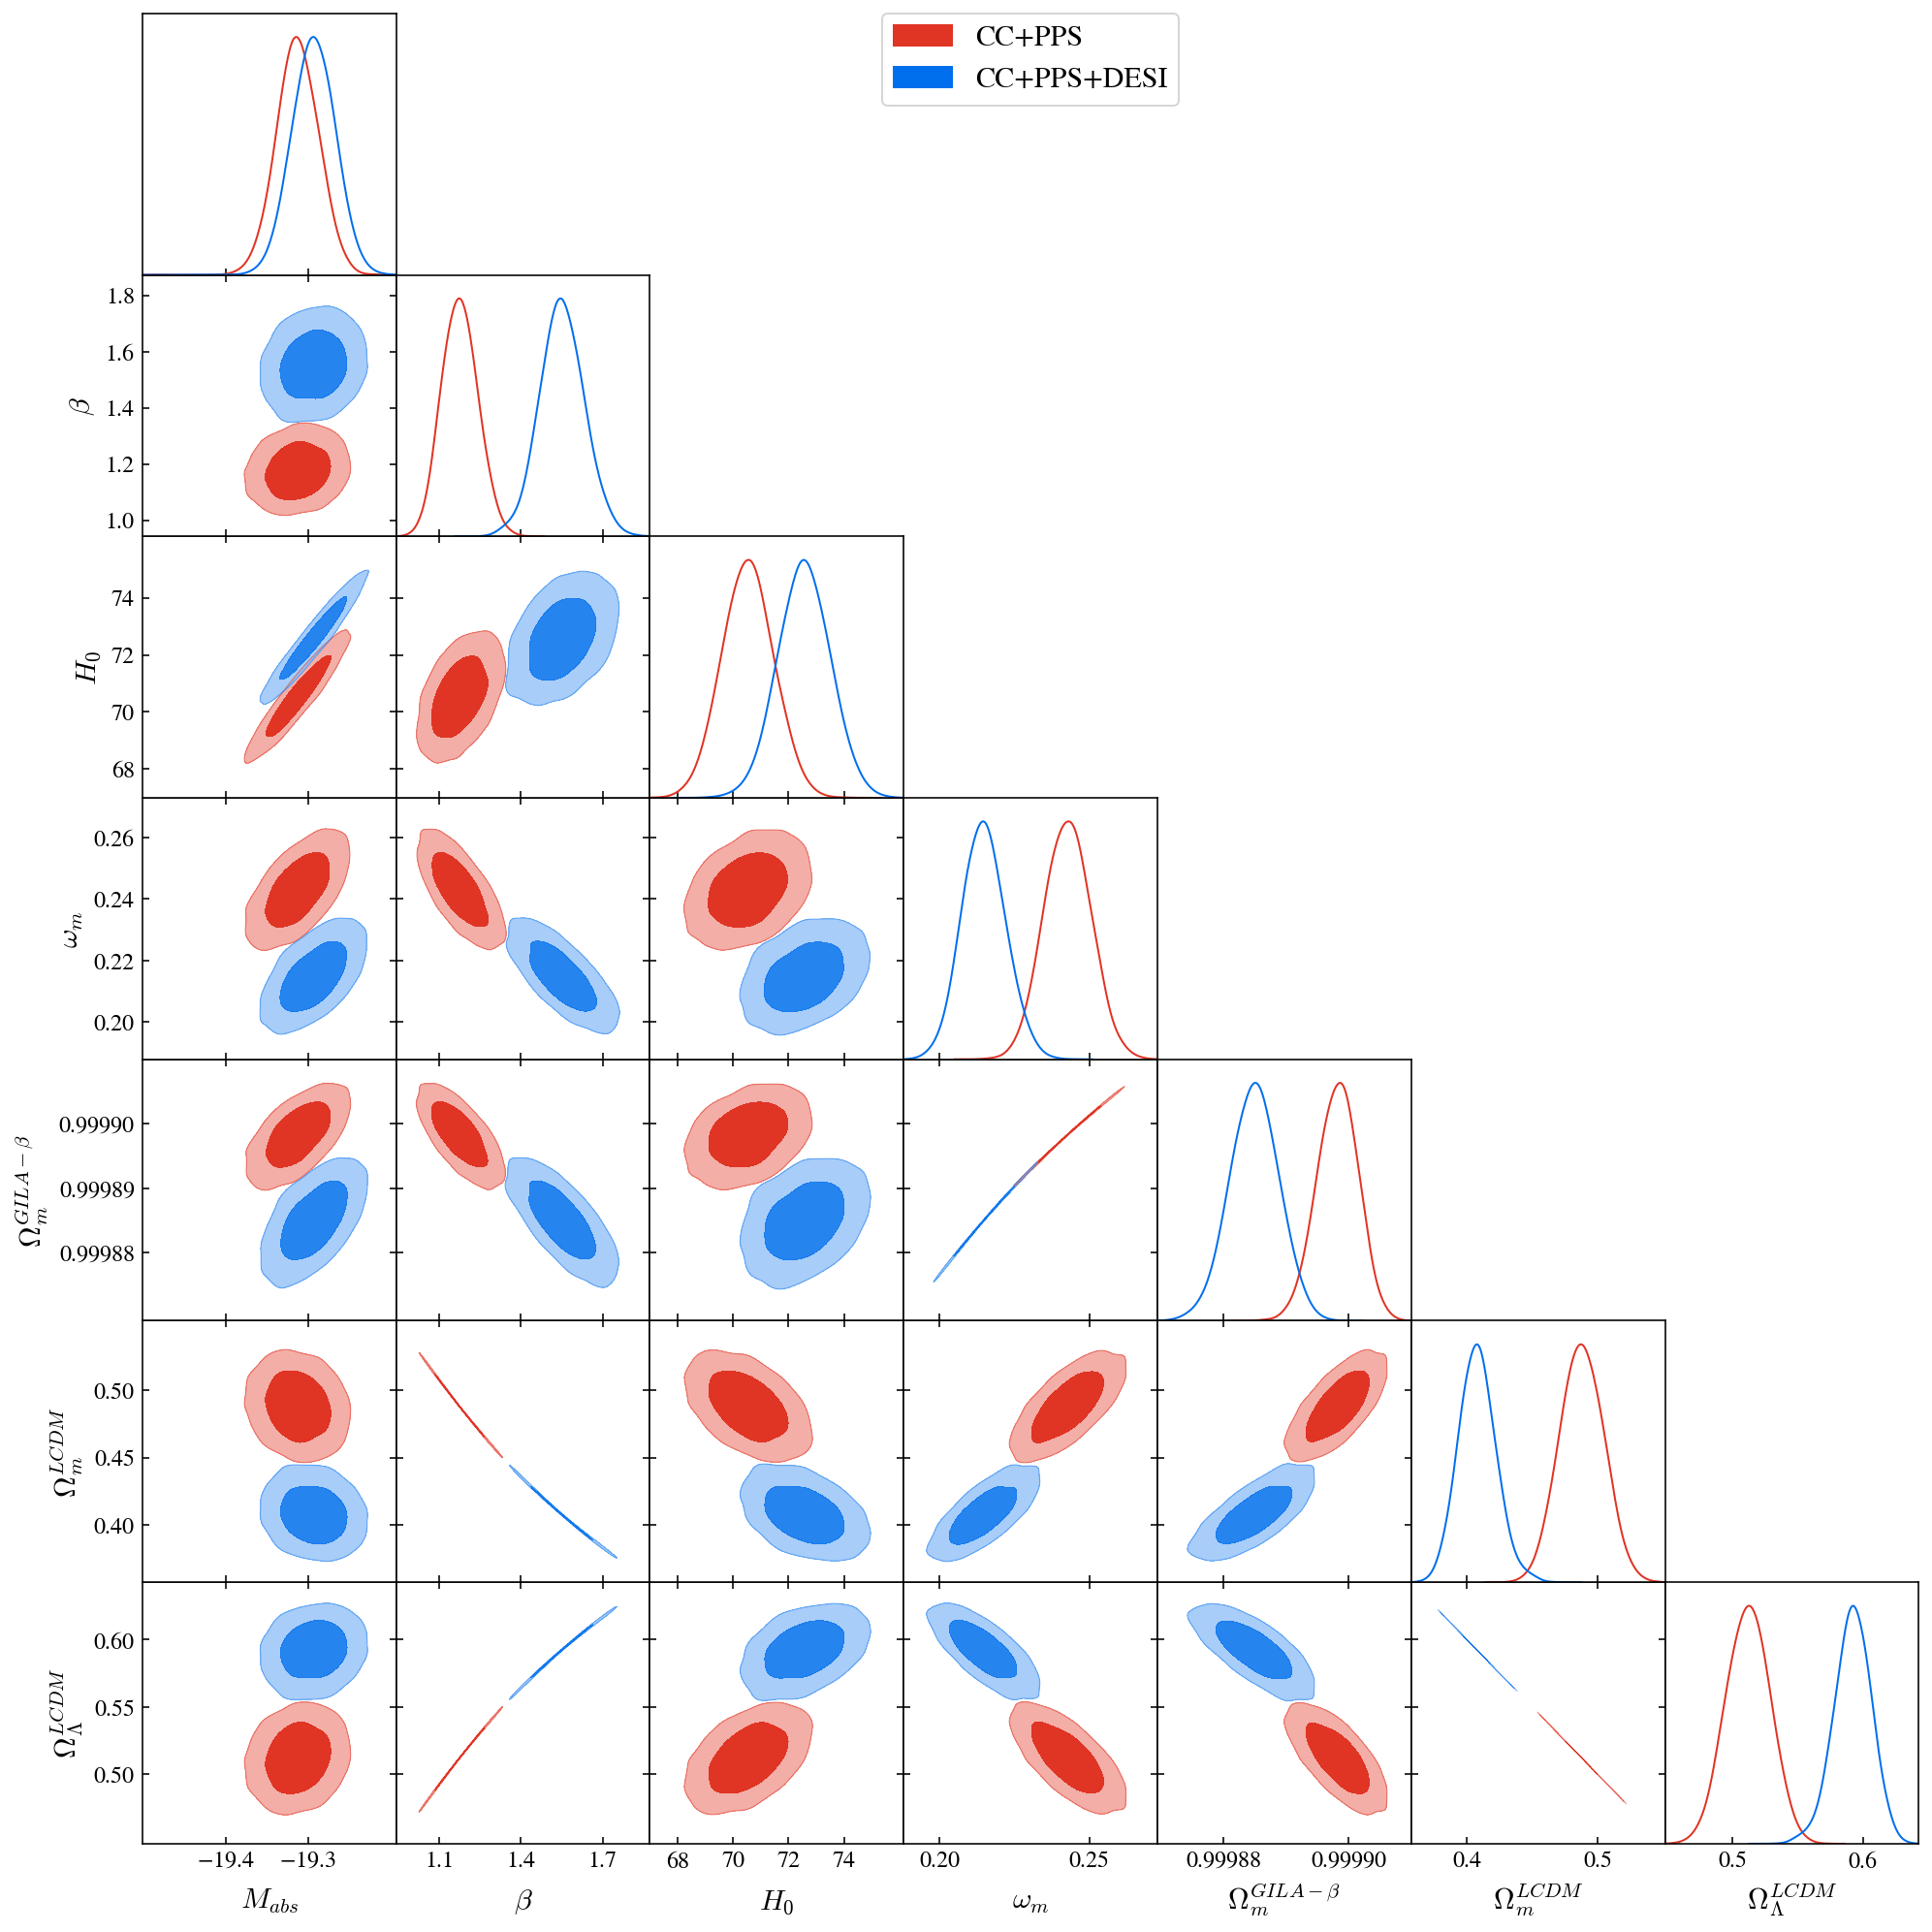

In [52]:
g = plots.get_subplot_plotter()
g.settings.legend_fontsize = 18
g.settings.axes_fontsize = 15
g.settings.axes_labelsize = 18
g.triangle_plot([samples2, samples2_desi],
				filled=True, params=names_GILA,
				contour_lws=1,
				legend_labels=['CC+PPS','CC+PPS+DESI'])
g.export(root_dic + 'triangle_plot_gila_CC+PPS+DESI_{}.pdf'.format(L_bar))

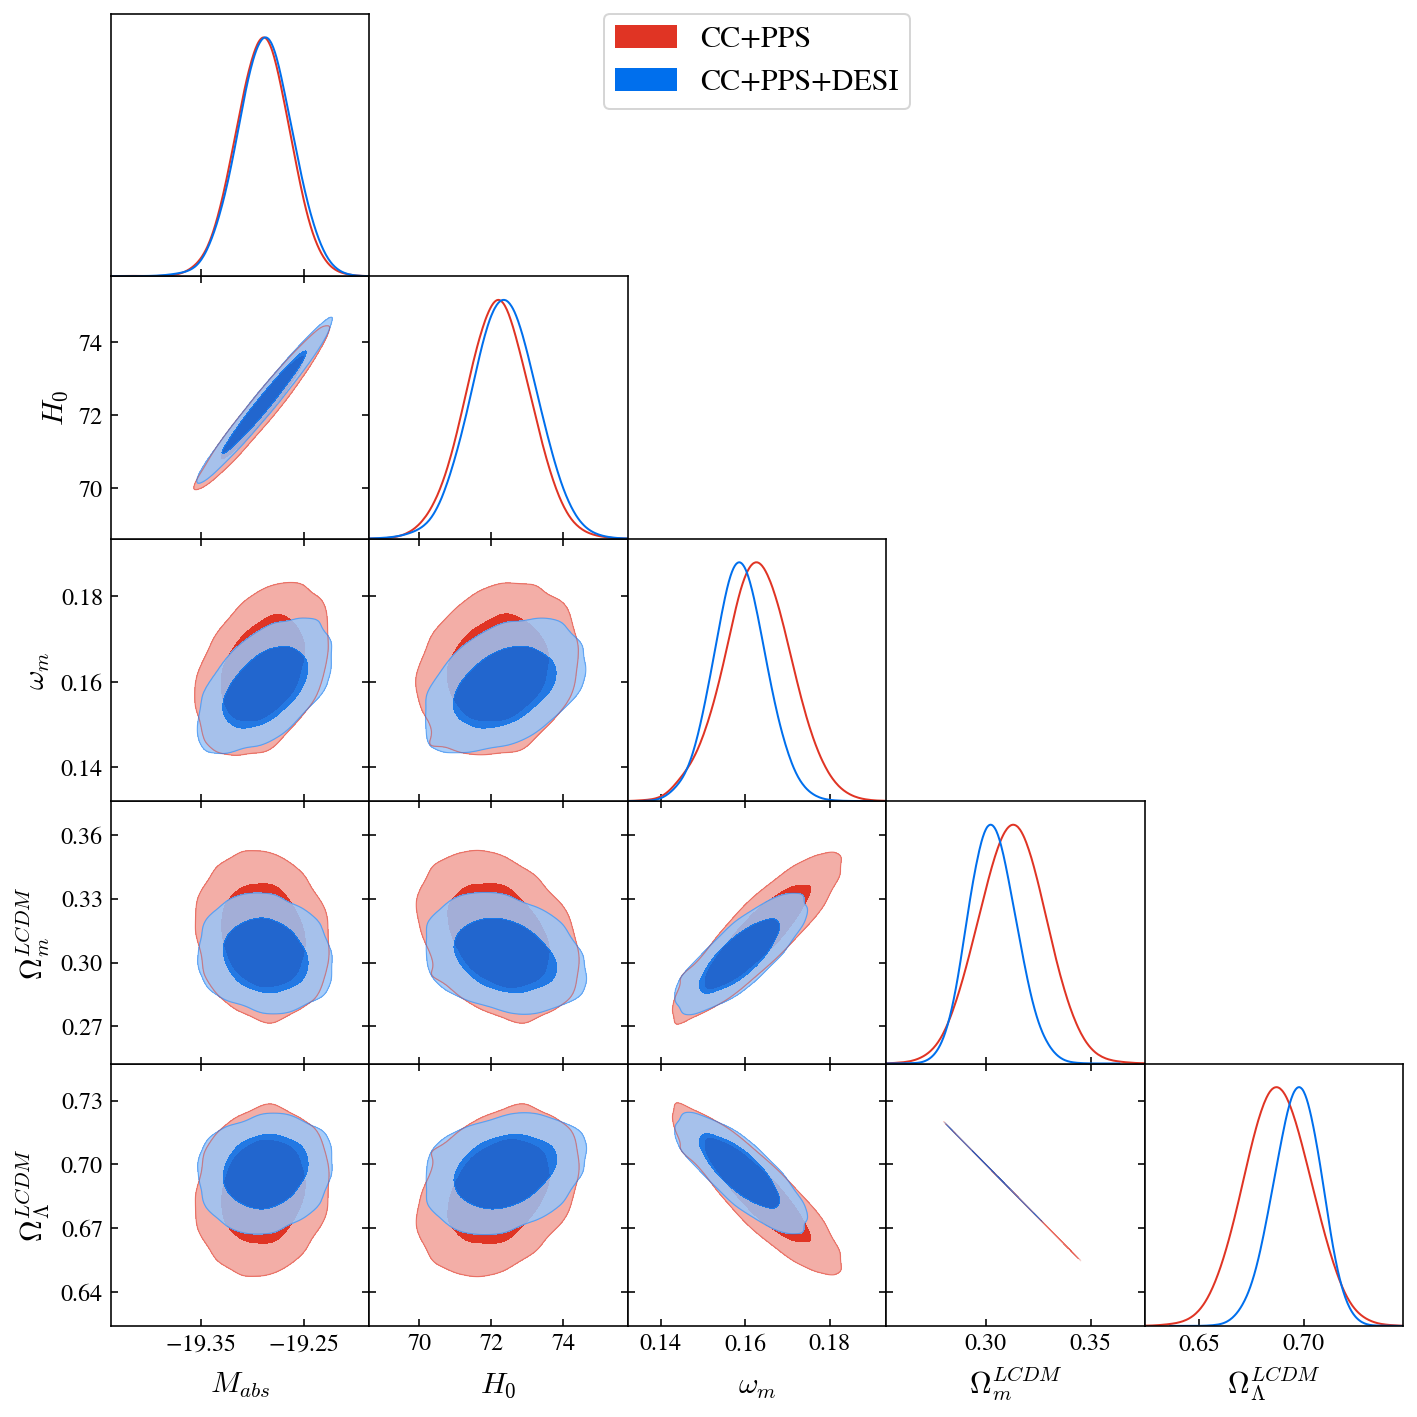

In [53]:
g = plots.get_subplot_plotter()
g.settings.legend_fontsize = 18
g.settings.axes_fontsize = 15
g.settings.axes_labelsize = 18
g.triangle_plot([samples3, samples3_desi],
				filled=True, params=names_LCDM,
				contour_lws=1,
				legend_labels=['CC+PPS','CC+PPS+DESI'])
g.export(root_dic + 'triangle_plot_lcdm_CC+PPS+DESI_{}.pdf'.format(L_bar))

In [54]:
def report_intervals(sampler, labels, discard=0, thin=1):
    if isinstance(sampler, np.ndarray)==True: #Posprocessed chains
        samples = sampler
        len_chain, ndim=samples.shape
    else:
        samples = sampler.get_chain(discard=discard, flat=True, thin=thin)
        len_chain, nwalkers, ndim = sampler.get_chain().shape

    #textfile_witness = open(save_path + '/intervals.dat','w')
    labels = labels
    for i in range(ndim):
        mean = np.mean(samples[:,i])
        one_s = 68
        two_s = 95

        one_sigma = az.hdi(samples,hdi_prob = one_s/100)[i]
        two_sigma = az.hdi(samples,hdi_prob = two_s/100)[i]

        q1 = np.diff([one_sigma[0],mean,one_sigma[1]])
        q2 = np.diff([two_sigma[0],mean,two_sigma[1]])

        if np.abs(one_sigma[0]) < 10**(-2): #Upper limit interval
            txt = "\mathrm{{{0}}} < {1:.3f}({2:.3f})"
            txt = txt.format(labels[i], mean + q1[1], mean + q2[1])

        else:
            txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}({4:.3f})}}^{{+{2:.3f}({5:.3f})}}"
            txt = txt.format(mean, q1[0], q1[1], labels[i], q2[0], q2[1])
        #textfile_witness.write('{} \n'.format(txt))
        print(txt)

In [55]:
from IPython.display import display, Math
import arviz as az
from scipy.stats import scoreatpercentile
from getdist import plots, MCSamples

#BETA intervals
print('Beta model intervals:')
report_intervals(chains_beta, names_GILA)
print('\n')


#GILA intervals
print('GILA model intervals:')
report_intervals(chains_gila, names_GILA)
print('\n')


#LCDM intervals
print('LCDM model intervals:')
report_intervals(chains_lcdm, names_LCDM)


Beta model intervals:
\mathrm{M_{{abs}}} = -19.308_{-0.024(0.048)}^{+0.026(0.051)}
\mathrm{\beta} = 0.744_{-0.031(0.060)}^{+0.031(0.062)}


/home/matias/anaconda3/envs/fR-MCMC/lib/python3.7/site-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


\mathrm{H_0} = 71.470_{-0.911(1.696)}^{+0.838(1.828)}
\mathrm{\omega_m} = 0.235_{-0.007(0.015)}^{+0.008(0.015)}
\mathrm{\Omega_{{m}}^{{GILA-\beta}}} = 1.000_{-0.000(0.000)}^{+0.000(0.000)}
\mathrm{\Omega_{{m}}^{{LCDM}}} = 0.460_{-0.015(0.030)}^{+0.015(0.030)}
\mathrm{\Omega_{{\Lambda}}^{{LCDM}}} = 0.540_{-0.015(0.030)}^{+0.015(0.030)}


GILA model intervals:
\mathrm{M_{{abs}}} = -19.313_{-0.024(0.049)}^{+0.025(0.049)}
\mathrm{\beta} = 1.177_{-0.071(0.121)}^{+0.058(0.128)}
\mathrm{H_0} = 70.527_{-0.952(1.746)}^{+0.855(1.789)}
\mathrm{\omega_m} = 0.243_{-0.008(0.015)}^{+0.007(0.015)}
\mathrm{\Omega_{{m}}^{{GILA-\beta}}} = 1.000_{-0.000(0.000)}^{+0.000(0.000)}
\mathrm{\Omega_{{m}}^{{LCDM}}} = 0.488_{-0.016(0.032)}^{+0.017(0.031)}
\mathrm{\Omega_{{\Lambda}}^{{LCDM}}} = 0.512_{-0.017(0.031)}^{+0.016(0.032)}


LCDM model intervals:
\mathrm{M_{{abs}}} = -19.290_{-0.025(0.051)}^{+0.025(0.049)}
\mathrm{H_0} = 72.188_{-0.819(1.773)}^{+0.928(1.698)}
\mathrm{\omega_m} = 0.163_{-0.007(0.016)}^{+0.0

/home/matias/anaconda3/envs/fR-MCMC/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':
/home/matias/anaconda3/envs/fR-MCMC/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]


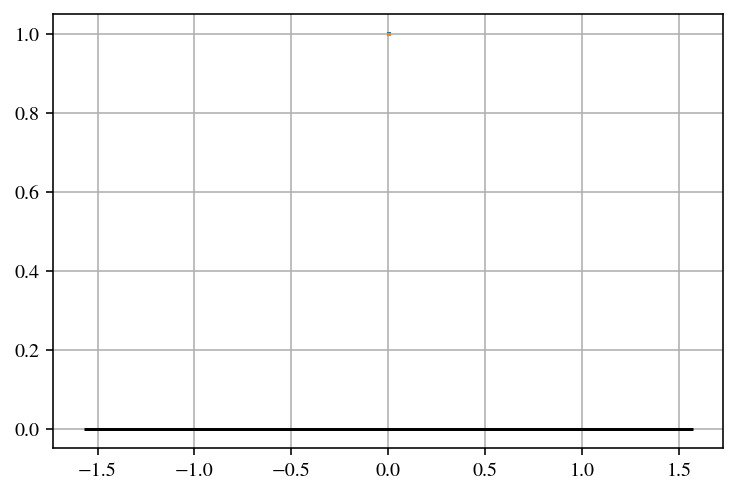

In [56]:
a = 0.8
#a = 0.99
#a = 1
#a= 1.1
a = 0.002
#a = 15

import numpy as np 
from matplotlib import pyplot as plt
phis = np.linspace(-np.pi/2,np.pi/2,1000)

plt.plot(phis, np.cos(phis)+np.sqrt(a**2  - np.sin(phis)**2))
plt.plot(phis, np.cos(phis)-np.sqrt(a**2  - np.sin(phis)**2))
plt.hlines(0,np.min(phis),np.max(phis))
plt.grid()